Using our [toolbox](http://neurolearn.readthedocs.io/en/latest/index.html) there's 2 main python classes that can help achieve ISC analysis:  

1) Brain_Data, which is a 1d or 2d representation of a nifti file. In the cases of something like an image with 1 value at each voxel (e.g beta map, T1, etc) this will be a single 1d vector of voxel values. In the case of something with more than 1 value at each voxel (e.g. fMRI time-series, concatenated beta-maps from multiple subjects), this will be a 2d vector of observations X  voxels.  

    - This class has a bunch of methods on it to do stuff like simple arithmetic operations, to more sophisticated things like regression, extracting a time-series from a mask, etc

2) Adjacency, which is a 1d or 2d representation of a distance matrix or several distance matrices. If theres just 1 distance matrix this will be a single 1d vector (i.e. flattened upper triangle if the matrix is symmetrical, or all values stretched out if it isn't). If there is more than 1 distance matrix this will be a 2d vector of observations X flattened matrix values.  

    - This class also has a bunch of methods just like Brain_Data

You'll need 2 things to do an ISC analysis:  

1) Nifti file(s) containing ROI masks within which to compute ISC - this can either be a single 4d file that several ROI masks within it, a single 3d file with just 1 ROI mask, a single 3d file within multiple ROIs indicated by different non-overlapping integer value at each voxel  

2) 4d Nifti files for all subjects to correlate

In [1]:
import nltools
from nltools.data import Brain_Data, Adjacency
from nltools.mask import expand_mask
from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

import os

% matplotlib inline




In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

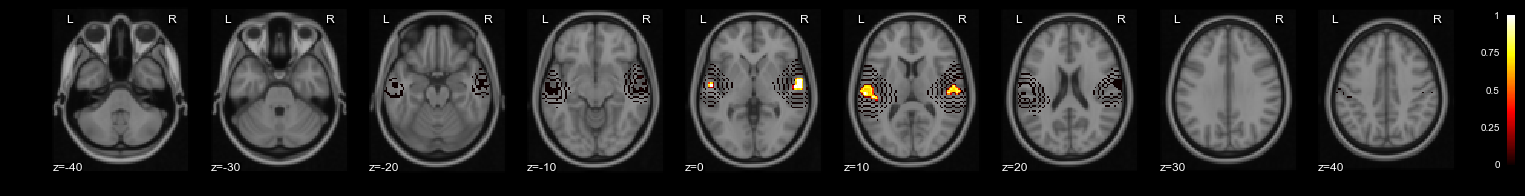

In [3]:
## Set up Folders

folder_path = "."

## Set up Mask

mask = 'a1_rev.nii'
mask_region = "a1_rev"

## Set up Video and Participantsd
video = 7
subjects = [ '145', '157', '168', '184', '200', '214',  '219', '220', '222', '223', '229', '245', '253', '257', '263',  '267', '270', '277']
num_subs = len(subjects)

subject = os.path.join(folder_path, 'data', 'sub-' + subjects[0], 'func', 'video_' + str(video) + '.nii.gz')
num_TRs = Brain_Data(subject).shape()[0]
    
    
# View Mask
mask = Brain_Data(data = folder_path + '/masked_csv/' + mask) # this now a 1d array of voxels containing 1's and 0s
mask.plot()

In [ ]:
#Lets say you want to compute the ISC within an ROI (i.e. the pair-wise correlation of subjects average time-series across the entire ROI)
#Below assumes you have just a single mask, but you can easily adapt this by adding another loop over ROIs, e.g. for roi in mask: ...

#Get masked timeseries (averaged)


for video in range(1,17):
    subjects = [ '145', '157', '168', '184', '200', '214',  '219', '220', '222', '223', '229', '245', '253', '257', '263',  '267', '270', '277']
    num_subs = len(subjects)

    subject = os.path.join(folder_path, 'data', 'sub-' + subjects[0], 'func', 'video_' + str(video) + '.nii.gz')
    num_TRs = Brain_Data(subject).shape()[0]

    subject_timeseres = np.zeros((num_subs,num_TRs)) # initialize an empty matrix thats subjects X timeseries to save the extracted time-series 

    for i, subject in enumerate(subjects):

        try:

            subject_path = os.path.join(folder_path,'data', 'sub-' + subject, 'func', 'video_' + str(video) + '.nii.gz')
            print(subject_path)

            # Load in their data
            sub_dat = Brain_Data(subject_path)

            # Extract mean time-series from ROI
            sub_roi = sub_dat.extract_roi(mask)

            data_frame = pd.DataFrame(sub_roi)
            output = os.path.join(folder_path, 'masked_csv', mask_region, subject + '_video' + str(video) + 'mask.csv')

            data_frame.to_csv(output, header=None)

        except:
            print(subject_path + " failed")
            pass

In [ ]:
pd.DataFrame(subject_timeseres)
pairwise_distances(subject_timeseres,metric='correlation')


In [ ]:
## Load data and compute ISC

for video in range(1,2):

    #Cutting off time series as a problem solivng measure
    subject = os.path.join(folder_path, 'data', 'sub-' + subjects[0], 'func', 'video_' + str(video) + '.nii.gz')

    num_TRs = Brain_Data(subject).shape()[0] - 3

    subject_timeseres = np.zeros((num_subs,num_TRs)) # initialize an empty matrix thats subjects X timeseries to save the extracted time-series 

    for i, subject in enumerate(subjects):
        csv_path = os.path.join(folder_path, 'masked_csv', mask_region,  subject + "_video" + str(video) + "mask.csv")
        #print(subject)

        try: 
            # Load in their data
            sub_roi = pd.read_csv(csv_path, header=None)
            subject_timeseres[i,:] = pd.DataFrame(sub_roi).iloc[ 0:num_TRs ,1] # just grab the numpy array values (normally just [1])
        except: pass

    # Now compute pairwise correlations 
    sub_corrs = 1 - pairwise_distances(subject_timeseres,metric='correlation') # I'm subtracting by 1 because pairwise_distance gives you correlation distances (i.e. values from 0-2), this just converts from -1 to 1

    panda_corrs = pd.DataFrame(sub_corrs)
    panda_corrs.columns = subjects
    panda_corrs.index = subjects

    pd.DataFrame(panda_corrs).to_csv('./masked_csv/' + mask_region + '/video_' \
                                      + str(video)\
                                      + '_fMRIcorrelations.csv')



    # Save it as an adjacency matrix
    sub_ISC = Adjacency(data=sub_corrs)

panda_corrs

# For plotting videos of aud1

In [ ]:
    subject = os.path.join(folder_path, 'data', 'sub-' + subjects[0], 'func', 'video_' + str(video) + '.nii.gz')

Brain_Data(subject).shape()[0]


In [20]:
for video in range(15,17):
    #Cutting off time series as a problem solivng measure
    subject = os.path.join(folder_path, 'data', 'sub-' + subjects[0], 'func', 'video_' + str(video) + '.nii.gz')
    

    num_TRs = Brain_Data(subject).shape()[0] - 5


    subject_timeseres = np.zeros((num_subs,num_TRs)) # initialize an empty matrix thats subjects X timeseries to save the extracted time-series 

    for i, subject in enumerate(subjects):
        csv_path = os.path.join(folder_path, 'masked_csv', mask_region,  subject + "_video" + str(video) + "mask.csv")

        try: 
                # Load in their data
            sub_roi = pd.read_csv(csv_path, header=None)
            sub_roi = sub_roi.transpose()#only for aud_1
            subject_timeseres[i,:] = pd.DataFrame(sub_roi).iloc[ 1:num_TRs + 1,0] # just grab the numpy array values (normally just [1])
        except: pass


    # Now compute pairwise correlations 
    sub_corrs = 1 - pairwise_distances(subject_timeseres,metric='correlation') # I'm subtracting by 1 because pairwise_distance gives you correlation distances (i.e. values from 0-2), this just converts from -1 to 1

    panda_corrs = pd.DataFrame(sub_corrs)
    panda_corrs.columns = subjects
    panda_corrs.index = subjects


    pd.DataFrame(panda_corrs).to_csv('./masked_csv/' + mask_region + '/video_' \
                                      + str(video)\
                                      + '_fMRIcorrelations.csv')


    # Save it as an adjacency matrix
    sub_ISC = Adjacency(data=sub_corrs)


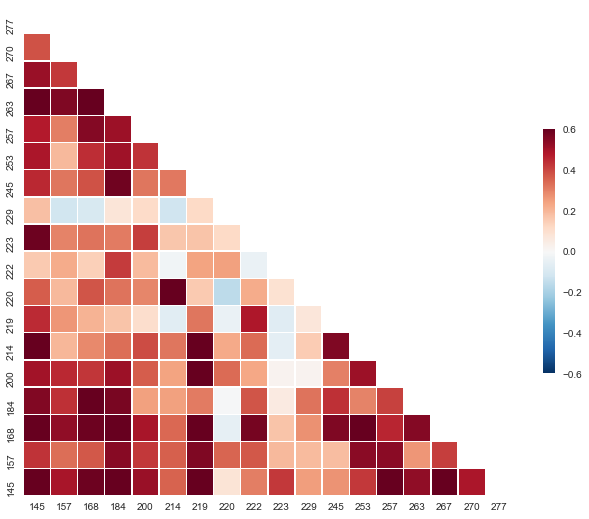

In [17]:
## Plot Group ISC

sns.set(style="white")

# Compute the correlation matrix
corr = sub_corrs

# Genesampling_rate a mask for the upper triangle
mask2 = np.zeros_like(corr, dtype=np.bool)
mask2[np.triu_indices_from(mask2)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))


sns.heatmap(corr, vmax=.6, center=0,
            square=True, mask=mask2, linewidths=.5, cbar_kws={"shrink": .5})

ax.set_xticklabels(subjects); 
ax.set_yticklabels(subjects); 

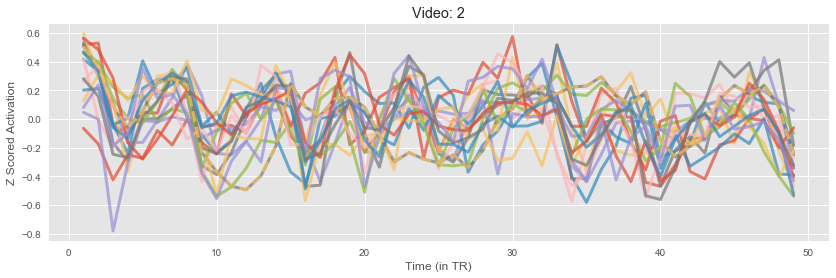

In [18]:
# Plot ISC Timeseries

plot_timeseries = pd.DataFrame(subject_timeseres).transpose().reset_index()
plot_timeseries = (plot_timeseries - plot_timeseries.mean()) / (plot_timeseries.max() - plot_timeseries.min())

plot_timeseries = plot_timeseries.loc[:, (plot_timeseries != 0).any(axis=0)]
plot_timeseries['index'] = plot_timeseries.index + 1

x = plot_timeseries['index']
y = plot_timeseries.drop(['index'], axis=1)

plt.figure(figsize=(14,4))
plt.style.use('ggplot')

plt.title("Video: " + str(video))
plt.ylabel('Z Scored Activation')
plt.xlabel('Time (in TR)')


plt.plot(x, y, '-', linewidth=3, alpha=.7);




x = plot_timeseries['index']
y = plot_timeseries[10]

plt.plot(x, y, '--', linewidth=3, alpha=.7);

In [9]:
# # Compute Subject Level Z-Scored Correlations
# transformedcorrs = pd.DataFrame(sub_corrs)
# transformedcorrs = transformedcorrs.replace(1,nan)
# #transformedcorrs = 0.5*np.log((1+transformedcorrs)/(1-transformedcorrs))

# transformedcorrs.mean()

# transformedcorrs


Few other pointers:  

If you want to do ISC for multiple ROIs you'll probably want to do something like load in a single subject, loop over a `Brain_Data` object containing multiple ROIs, use the `extract` method to grab mean timeseries from each, then save all those to a single csv file for that subject using pandas or numpy. Then after you've done that for each subject just load in their csv files and proceed with correlating them as you want. This probably the fastest way to do it because very few computers can load say 30 subjects full time-series of a few minutes into RAM at once (unless maybe the time-series are very short). So this way just extracts all the ROIs for each subject first then lets you do whatever analyses you want on them. 